In [1]:
!pip3 install tqdm pandas opencv-python scikit-learn
!apt-get -y install libgl1-mesa-glx

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


# import

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

# Load && Hyper Parameter

In [3]:
vir_path = "./dataset/vir"
img_path = "./dataset/img256"
image_w = 256
image_h = 256
input_shape = (image_w, image_h, 1)

In [4]:
malware_df =pd.read_csv("./dataset/malware1.csv")
malware_df.head()

,Unnamed: 0,vir,png,len,malware
0,0,0003c3dd20cd99cf4555ab7c9232ec9c.vir,0003c3dd20cd99cf4555ab7c9232ec9c.png,192902,1
1,1,000590557e79980e147c3ff6521ec5cc.vir,000590557e79980e147c3ff6521ec5cc.png,199684,1
2,2,0006c099239df9bcaab4c3cbc85e6ff8.vir,0006c099239df9bcaab4c3cbc85e6ff8.png,42340,0
3,3,000fbf210ae21ff7604c025e1763a149.vir,000fbf210ae21ff7604c025e1763a149.png,440988,1
4,4,00123e9b2a49b6750df39ad0e86508e2.vir,00123e9b2a49b6750df39ad0e86508e2.png,614478,0


# Create Train, Val Dataset

In [5]:
x = []
y = []

for idx, row in tqdm(malware_df.iterrows()):
    path = f"{img_path}/{row['png']}"
    malware_class = row['malware']
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(image_w,image_h,1)
    
    x.append(img/255.)
    y.append(malware_class)
    
x = np.array(x)
y = np.array(y)
    
train_img, val_img, train_label, val_label = train_test_split(x, 
                                                  y, 
                                                  stratify=y, 
                                                  test_size=0.1)

15000it [00:12, 1174.13it/s]


In [6]:
train_img.shape, val_img.shape, train_label.shape, val_label.shape

((13500, 256, 256, 1), (1500, 256, 256, 1), (13500,), (1500,))

# Def Model

In [7]:
def VGG16():
    vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=input_shape)
    
    model = tf.keras.models.Sequential([
        vgg16,
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [8]:
def ResNet50():
    resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights=None, input_shape=input_shape)
    
    model = tf.keras.models.Sequential([
        resnet50,
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    return model

# Train

In [29]:
folder_name = "malware_vgg16"
if not os.path.exists(f"./model/{folder_name}"):
    os.mkdir(f"./model/{folder_name}")
    print(f"create ./model/{folder_name}")
if not os.path.exists(f"./img/{folder_name}"):
    os.mkdir(f"./img/{folder_name}")
    print(f"create ./img/{folder_name}")

In [30]:
model = ResNet50()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23581440  
                                                                 
 dense_2 (Dense)             (None, 8, 8, 512)         1049088   
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,633,089
Trainable params: 24,578,945


In [31]:
save_path = f"./model/{folder_name}/"
checkpoint_path = save_path+"/model_{epoch}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

In [ ]:
history = model.fit(x=train_img, 
                    y=train_label, 
                    batch_size=16,
                    epochs=30, 
                    validation_data=(val_img, val_label), 
                    callbacks=[cp_callback]
                   )

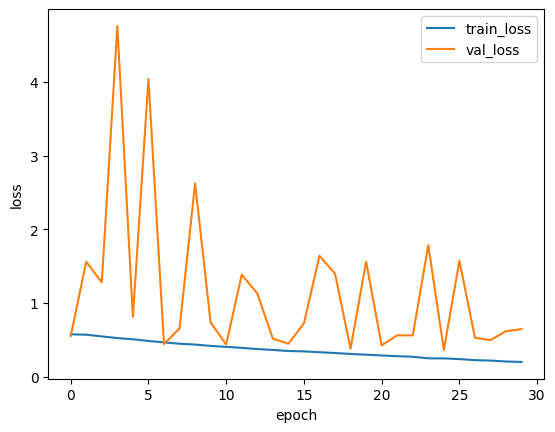

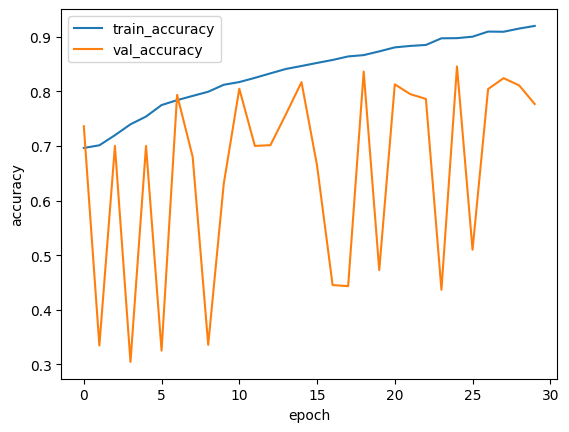

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.savefig(f"./img/{folder_name}/loss.png")
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.savefig(f"./img/{folder_name}/acc.png")
plt.show()